In [1]:
import graphviz

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['font.size'] = 15
plt.rcParams["figure.figsize"] = [11,11]

In [4]:
word1 = 'POLYNOMIAL'
word2 = 'EXPONENTIAL'
col_labels=['#'] + list(word1)
row_labels= ['#'] + list(word2)
table_vals= [[0 for i in range(len(col_labels))] for j in range(len(row_labels))]
# Edit distance initialization
for i in range(len(row_labels)):
    table_vals[i][0] = i
for i in range(len(col_labels)):
    table_vals[0][i] = i
    

In [5]:
# Edit distance dynamic programming
for i in range(1, len(row_labels)):
    for j in range(1, len(col_labels)):
        table_vals[i][j] = min(table_vals[i - 1][j - 1] + (1 if row_labels[i] != col_labels[j] else 0), table_vals[i][j - 1] + 1, table_vals[i - 1][j] + 1)

In [6]:
# Best path tracking in dynamic programming
n = len(row_labels) - 1
m = len(col_labels) - 1
line = [[m, n]]
while(n > 0 or m > 0):
    if n > 0 and table_vals[n][m] == table_vals[n - 1][m] + 1:
        n -= 1
    elif m > 0 and table_vals[n][m] == table_vals[n][m - 1] + 1:
        m -= 1
    else:
        n -= 1
        m -= 1
    line.append([m, n])

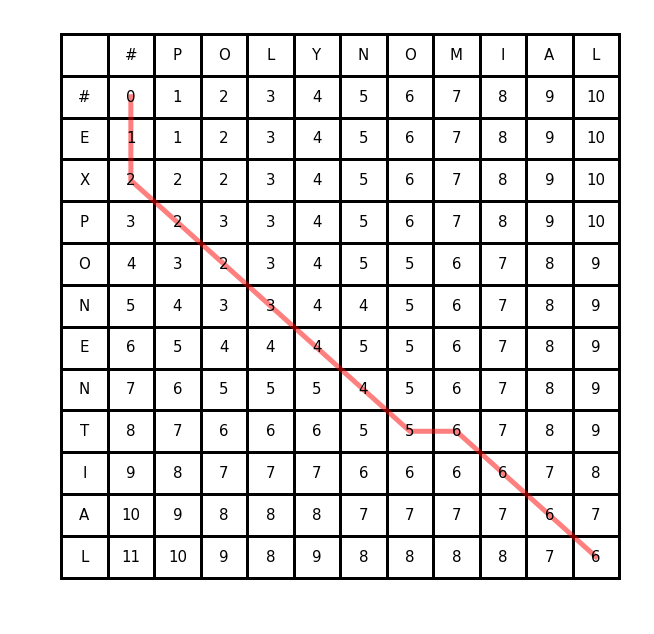

In [7]:
# Drawing
def draw_table(col_labels, row_labels, table_vals, line=None):
    if not line is None:
        line = np.array(line)
        line = line.transpose()

    ncol = len(col_labels)
    nrow = len(row_labels)

    # draw grid lines
    plt.plot(np.tile([0, ncol+1], (nrow+2,1)).T, np.tile(np.arange(nrow+2), (2,1)),
        'k', linewidth=3)
    plt.plot(np.tile(np.arange(ncol+2), (2,1)), np.tile([0, nrow+1], (ncol+2,1)).T,
        'k', linewidth=3)

    # plot labels
    for icol, col in enumerate(col_labels):
        plt.text(icol + 1.5, nrow + 0.5, col, ha='center', va='center')
    for irow, row in enumerate(row_labels):
        plt.text(0.5, nrow - irow - 0.5, row, ha='center', va='center')

    # plot table content
    for irow, row in enumerate(table_vals):
        for icol, cell in enumerate(row):
            plt.text(icol + 1.5, nrow - irow - 0.5, cell, ha='center', va='center')

    # plot line
    if not line is None:
        plt.plot(line[0] + 1.5, nrow - line[1] - 0.5, 'r', linewidth = 5, alpha = 0.5)

    #plt.axis([-0.5, ncol + 1.5, -0.5, nrow+1.5])
    plt.axis('off')
    plt.show()
draw_table(col_labels, row_labels, table_vals, line)

In [8]:
ed_graph = graphviz.Digraph(comment='Graph of \"КОМАНДА\"')

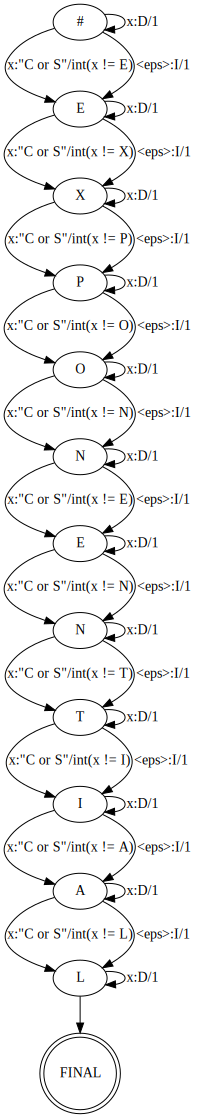

In [9]:
for i in range(len(row_labels)):
    ed_graph.node(str(i), row_labels[i])
for i in range(len(row_labels) - 1):
    ed_graph.edge(str(i), str(i + 1), f' x:\"C or S\"/int(x != {row_labels[i + 1]})')
for i in range(len(row_labels) - 1):
    ed_graph.edge(str(i), str(i + 1), f' <eps>:I/1')
for i in range(len(row_labels)):
    ed_graph.edge(str(i), str(i), f' x:D/1')

ed_graph.node(str(len(row_labels)), 'FINAL', shape='doublecircle')
ed_graph.edge(str(len(row_labels) - 1), str(len(row_labels)))
ed_graph

In [10]:
table_vals_tokens = [['@' for i in range(len(col_labels))] for j in range(len(row_labels))]
class Token:
    def __init__(self, history_item, dist):
        self.history_item = history_item
        self.dist = dist
    def __str__(self):
        return '{' + self.history_item + ' ' + str(self.dist) + '}'
    def __repr__(self):
        return '{' + self.history_item + ' ' + str(self.dist) + '}'


tokens = { 0:Token('', 0) }
beam = 2
        
#eps initialization
for state in range(len(row_labels) - 1):
    if state + 1 not in tokens or tokens[state + 1].dist > tokens[state].dist + 1:
        tokens[state + 1] = Token(
            tokens[state].history_item + f'I({row_labels[state + 1]})',
            tokens[state].dist + 1
        )
#beam cutoff
best_cost = min([token.dist for token in tokens.values()])
tokens = {state:token for state,token in tokens.items() if token.dist <= best_cost + beam}
        
for state in tokens:
    table_vals_tokens[state][0] = tokens[state].dist

for i in range(1, len(col_labels)):
    new_tokens = {}
    # non-eps transitions
    for state in sorted(tokens):
        #sub or cor
        if len(row_labels) > state + 1 and (not state + 1 in new_tokens or 
                                            new_tokens[state + 1].dist > tokens[state].dist + (1 if row_labels[state + 1] != col_labels[i] else 0)):
            new_tokens[state + 1] = Token(
                tokens[state].history_item + (f'S({col_labels[i]}->{row_labels[state + 1]})' if row_labels[state + 1] != col_labels[i] else 'C'),
                tokens[state].dist + (1 if row_labels[state + 1] != col_labels[i] else 0)
            )
        #del
        if not state in new_tokens or new_tokens[state].dist > tokens[state].dist + 1:
            new_tokens[state] = Token(
                tokens[state].history_item + 'D',
                tokens[state].dist + 1
            )
    # eps transitions
    # На самом деле этот цикл работает неправильно, так как new_tokens обновляется, а stata бегает только по исходным
    for state in sorted(new_tokens):
        if len(row_labels) > state + 1 and (state + 1 not in new_tokens or 
                                            new_tokens[state + 1].dist > new_tokens[state].dist + 1):
            new_tokens[state + 1] = Token(
                new_tokens[state].history_item + f'I({row_labels[state + 1]})',
                new_tokens[state].dist + 1
            )
        
    best_cost = min([token.dist for token in new_tokens.values()])
    #beam cutoff
    new_tokens = {state:token for state,token in new_tokens.items() if token.dist <= best_cost + beam}
    tokens = new_tokens
    print(i, tokens)
    for state in tokens:
        table_vals_tokens[state][i] = tokens[state].dist

1 {1: {S(P->E) 1}, 0: {D 1}, 2: {I(E)S(P->X) 2}, 3: {I(E)I(X)C 2}, 4: {I(E)I(X)CI(O) 3}}
2 {1: {DS(O->E) 2}, 0: {DD 2}, 2: {S(P->E)S(O->X) 2}, 3: {I(E)S(P->X)S(O->P) 3}, 4: {I(E)I(X)CC 2}, 5: {I(E)I(X)CCI(N) 3}, 6: {I(E)I(X)CCI(N)I(E) 4}}
3 {1: {DDS(L->E) 3}, 0: {DDD 3}, 2: {DS(O->E)S(L->X) 3}, 3: {S(P->E)S(O->X)S(L->P) 3}, 4: {I(E)I(X)CCD 3}, 5: {I(E)I(X)CCS(L->N) 3}, 6: {I(E)I(X)CCI(N)S(L->E) 4}, 7: {I(E)I(X)CCI(N)I(E)S(L->N) 5}}
4 {1: {DDDS(Y->E) 4}, 0: {DDDD 4}, 2: {DDS(L->E)S(Y->X) 4}, 3: {DS(O->E)S(L->X)S(Y->P) 4}, 4: {S(P->E)S(O->X)S(L->P)S(Y->O) 4}, 5: {I(E)I(X)CCDS(Y->N) 4}, 6: {I(E)I(X)CCS(L->N)S(Y->E) 4}, 7: {I(E)I(X)CCI(N)S(L->E)S(Y->N) 5}, 8: {I(E)I(X)CCI(N)I(E)S(L->N)S(Y->T) 6}}
5 {1: {DDDDS(N->E) 5}, 0: {DDDDD 5}, 2: {DDDS(Y->E)S(N->X) 5}, 3: {DDS(L->E)S(Y->X)S(N->P) 5}, 4: {DS(O->E)S(L->X)S(Y->P)S(N->O) 5}, 5: {S(P->E)S(O->X)S(L->P)S(Y->O)C 4}, 6: {I(E)I(X)CCDS(Y->N)S(N->E) 5}, 7: {I(E)I(X)CCS(L->N)S(Y->E)C 4}, 8: {I(E)I(X)CCS(L->N)S(Y->E)CI(T) 5}, 9: {I(E)I(X)CCS(L->N)

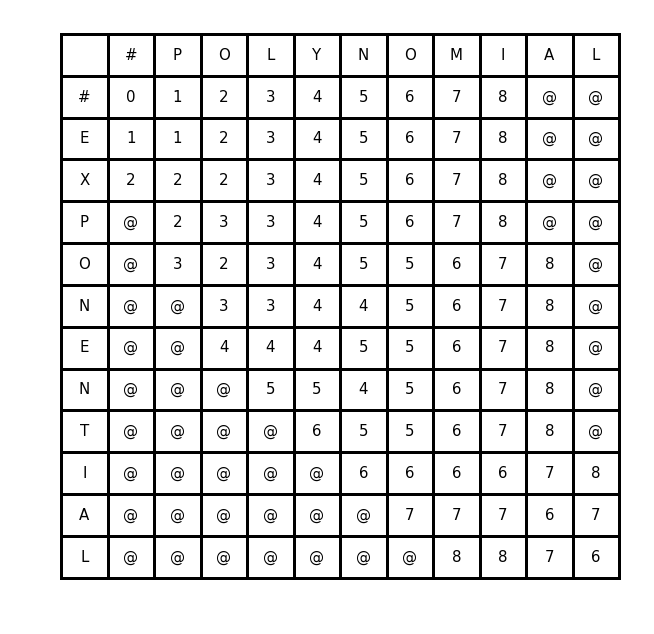

In [11]:
draw_table(col_labels, row_labels, table_vals_tokens)

In [13]:
# Формат: I(char) вставить букву char, D -- удалить текущую букву, 
# C -- сдвинуться вправо, S(char1->char2) заменить текущую букву char1 на char2 и сдвинуться вправо
print(tokens[len(row_labels) - 1])

{I(E)I(X)CCS(L->N)S(Y->E)CDS(M->T)CCC 6}
